In [1]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Google Drive path where coursework material is available
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Dissertation'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Model_5_ANN.ipynb', 'accepted_2013_to_2018_filtered.csv', 'FINAL_unbalancedData.csv', 'Final_balanced_data.csv', 'Cleaned_data.csv', 'accepted_2013_to_2018_latest1.csv', 'accepted_2013_to_2018_latest.csv', 'accepted_2007_to_2018q4.csv.zip', 'XGBoost_model.ipynb', 'Cleaned_data_dummy.csv', 'NN_Keras.ipynb', '3_Filter Individual_loans_EDA_ and_cleaning.ipynb', 'y_data.csv', 'x_data.csv', 'Copy of Individual_loans_hypothesisTesting.ipynb', 'FINAL_balancedData.csv', 'FINAL_forModeling.csv', 'ANN_model.joblib', 'Decsion_tree_model.joblib', 'Random_fores.joblib', '4_Individual_loans_hypothesisTesting_and_undersampling.ipynb', 'FINAL_balancedData_testing.csv', 'XGBoost_model.joblib', 'XAI_RandomForest.ipynb', '2_Filter_data_on_Loan_status.ipynb', 'Random_forest_model.ipynb', 'Copy of 3_Filter Individual_loans_EDA_ and_cleaning.ipynb', 'Untitled0.ipynb', '1_Filter_data_2013_to_2018.ipynb', 'Logistic_Regression.joblib', 'Model_1_Logistic_regression.ipynb', 'Model_2_Decesion_Tree.ipynb', 'Mode

In [3]:
#Install skorch library as it is not available directly in colab
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 1.7 MB/s eta 0:00:00


In [38]:
#Read required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
import torch
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,auc,recall_score,classification_report,f1_score,precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
import joblib
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as  plt
from skorch.callbacks import Checkpoint
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

In [5]:
#Read dependent variable 'y' and independent variable 'X'
X = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'x_data.csv'))
y = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'y_data.csv'))

In [ ]:
#to display all features and observations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
#Split the data into train and test in 80:20 ratio
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 129)

In [ ]:
x_train.head() #display top 5 observation of train independent variables

,int_rate,sub_grade,term_years,inq_last_6mths,grade,mths_since_last_delinq,num_tl_op_past_12m,Not Verified,acc_open_past_24mths,MORTGAGE,fico_score,num_rev_tl_bal_gt_0,emp_length_years,Source Verified,mths_since_last_record,num_actv_rev_tl,pub_rec,Verified,mths_since_recent_inq,mort_acc
658486,11.490000,9,3,0.0,1,999.000000,2.0,1,3.000000,0,692.000000,5.000000,7.000000,0,999.000000,5.000000,0.0,0,20.00000,0.000000
80012,7.890000,4,3,0.0,0,999.000000,0.0,1,0.000000,1,742.000000,2.000000,10.000000,0,999.000000,2.000000,0.0,0,5.00000,1.000000
768386,13.330000,12,3,0.0,2,7.000000,0.0,0,2.000000,1,672.000000,4.000000,1.000000,1,999.000000,4.000000,0.0,0,5.00000,6.000000
477378,8.990000,5,3,1.0,1,47.000000,2.0,0,3.000000,1,672.000000,4.000000,5.000000,1,999.000000,4.000000,0.0,0,6.00000,4.000000
23946,20.533328,22,3,1.0,4,16.250947,3.0,0,5.812737,0,697.936316,2.374526,9.625474,0,107.936316,2.374526,1.0,0,2.43821,0.187263


In [ ]:
y_train.head()

,loan_status
658486,0
80012,0
768386,0
477378,0
23946,1


In [16]:
#Initially data without scaling was giving bad performance in neural network, standard scaling improve the overall performance
scaler = StandardScaler()

In [17]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [18]:
# #Convert to numpy array
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

In [9]:
#Define input, output and dropout
input_layer = 20 # input is 20 as there are twenty predictors
# hidden_layers = [100,50] # experimented with different hidden layers list defines first hidden layer has 100 neurons and second has 50
hidden_layers = [100, 120, 50] # experimented with different hidden layers list defines first hidden layer has 100 neurons and second has 120 and third has 50 neurons
# hidden_layers = [50,100, 120]
# hidden_layers = [10,20]
output_layer = 2 #it is a binary classification, so two perceptrons in output layer
dropout = 0.4#experimented with different value of dropout 0.5 and 0.4

In [32]:
#Define feed forward network
#Code Partially Adapted from Neural network module coursework
class credit_net(nn.Module):
    def __init__(self,
                 input_dim = input_layer,
                 hidden_dim = hidden_layers,
                 output_dim = output_layer,
                 dropout = dropout
                ):
        super(credit_net, self).__init__() #instantiate nn.module
        self.fc1= nn.Linear(input_layer, hidden_layers[0]) #20 features will have 20 neurons in input layer
        self.dropout = nn.Dropout(dropout)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers)-1)])

        self.out = nn.Linear(hidden_dim[-1] ,output_layer)
        self.relu = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim =-1)





    def forward(self, x): #x is input
        x = self.relu(self.fc1(x)) #activation function is firing here
        x = self.dropout(x)#droput
        for layer in self.hidden_layers: # to reduce the code we have used for loop to define hidden layer instead of explicily define each layer
            x = self.LeakyReLU(layer(x))
            x = self.dropout(x)

        x = self.softmax(self.out(x)) #softmax function firing on output layer, it will give probability of each class(gamma or Hadron)


        return x

In [26]:
net = credit_net()
print(net)

credit_net(
  (fc1): Linear(in_features=20, out_features=100, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=100, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=50, bias=True)
  )
  (out): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=-1)
)


In [19]:
x_train = x_train.astype(np.float32) #datatype required by skorch for model training
y_train = y_train.astype(np.int64)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int64)

In [22]:
x_test

array([[ 0.24600461,  0.4173042 ,  1.7155151 , ..., -0.6441997 ,
        -0.08059412,  0.7139478 ],
       [-0.46326673, -0.65325075, -0.5946651 , ..., -0.6441997 ,
        -0.9835357 ,  1.2265606 ],
       [ 0.48283988,  0.4173042 , -0.5946651 , ..., -0.6441997 ,
        -0.27349547,  1.2265606 ],
       ...,
       [-0.03278412, -0.04150508,  1.7155151 , ..., -0.6441997 ,
        -0.26118246, -0.3112779 ],
       [ 0.47969517,  0.4173042 , -0.5946651 , ..., -0.6441997 ,
        -0.26118246,  0.7139478 ],
       [ 0.47969517,  0.4173042 , -0.5946651 , ..., -0.6441997 ,
        -0.44177076, -0.82389075]], dtype=float32)

In [27]:
checkpoint = Checkpoint(monitor='valid_loss_best') #define checkpoint where model will be saved based on least loss

In [ ]:
# define model with their optimization functions, with different learning rates
net = NeuralNetClassifier(
    credit_net,
    criterion = nn.CrossEntropyLoss,
    lr=0.01,
    max_epochs=50,
    optimizer = torch.optim.Adam,
    optimizer__weight_decay=0.01,
    callbacks = [checkpoint]
 )

In [ ]:
# Train the model with best hyperparameters with noting down its time
#code adapted from computer vision and neural networks module lab
start_time = time.time()
net.fit(x_train,y_train)
end_time = time.time()
elapsed_time = end_time- start_time
print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        0.5819       0.7361        0.5726     +  29.9878
      2        0.5798       0.7346        0.5735        28.4188
      3        0.5798       0.7344        0.5681     +  29.3791
      4        0.5802       0.7381        0.5715        27.0781
      5        0.5795       0.7360        0.5725        27.3894
      6        0.5802       0.7379        0.5720        28.0103
      7        0.5799       0.7360        0.5732        27.7797
      8        0.5801       0.7362        0.5673     +  36.3320
      9        0.5795       0.7359        0.5687        28.9002
     10        0.5797       0.7356        0.5694        27.8790
     11        0.5798       0.7364        0.5722        28.8392
     12        0.5796       0.7396        0.5688        28.1697
     13        0.5796       0.7374        0.5674        28.2181
     14        0.5795       0.7344      

In [ ]:
# #load the parameters with least loss
net.load_params(checkpoint=checkpoint)

/usr/local/lib/python3.10/dist-packages/skorch/net.py:2626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f_name, map_location=map_location)


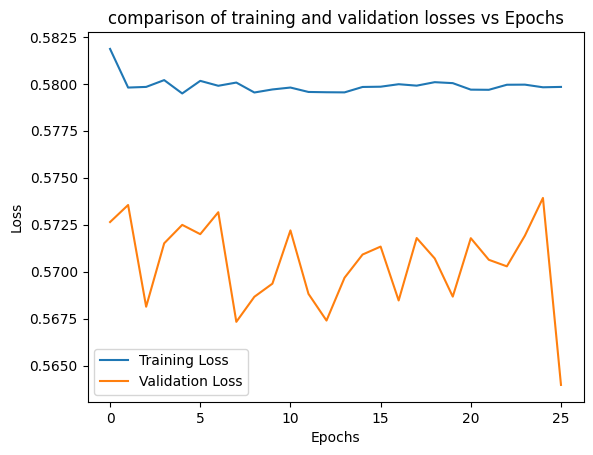

In [ ]:
#plot of epoch vs loss in validation and training loss #Adapted from neural computing lab
training_losses_mlp= net.history[:, 'train_loss']
validation_losses_mlp = net.history[:, 'valid_loss']

plt.plot(np.arange(len(training_losses_mlp)), training_losses_mlp, label='Training Loss', )
plt.plot(np.arange(len(validation_losses_mlp)), validation_losses_mlp, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.title('comparison of training and validation losses vs Epochs')
plt.show()

In [ ]:
y_pred = net.predict(x_test) #predict the output
y_pred

array([0, 0, 0, ..., 0, 0, 0])

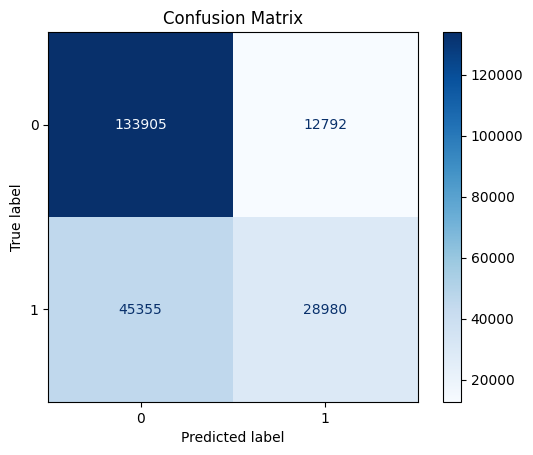

In [ ]:

cm_mlp = confusion_matrix(y_test, y_pred)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp_mlp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

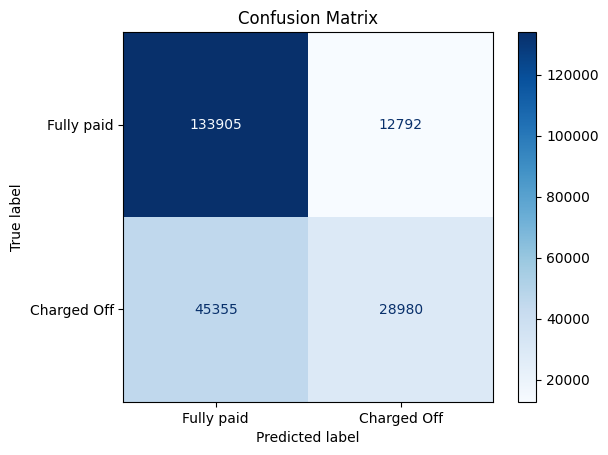

In [ ]:

cm_mlp = confusion_matrix(y_test, y_pred)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['Fully paid', 'Charged Off'])
disp_mlp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82    146697
           1       0.69      0.39      0.50     74335

    accuracy                           0.74    221032
   macro avg       0.72      0.65      0.66    221032
weighted avg       0.73      0.74      0.71    221032



In [39]:
# predictions to calculate performance metrices
y_train_pred_mlp = net.predict(x_train)
y_test_pred_mlp= = net.predict(x_test)
y_test_pred_proba_mlp = net.predict_proba(x_test)[:, 1]

# performance metrices
train_accuracy = accuracy_score(y_train, y_train_pred_mlp)
test_accuracy = accuracy_score(y_test, y_test_pred_mlp)
precision = precision_score(y_test, y_test_pred_mlp)
recall = recall_score(y_test, y_test_pred_mlp)
f1 = f1_score(y_test, y_test_pred_mlp)
auc = roc_auc_score(y_test, y_test_pred_proba_mlp)

# Print performance results
print(f"Train Accuracy of mlp: {train_accuracy*100}")
print(f"Test Accuracy of mlp: {test_accuracy*100}")
print(f"Precision of mlp: {precision*100}")
print(f"Recall mlp: {recall *100}")
print(f"F1 Score of mlp {f1*100}")
print(f"AUC of mlp: {auc *100}")

Train Accuracy of mlp: 73.69560447266566
Test Accuracy of mlp: 73.69294943718556
Precision of mlp: 69.37661591496696
Recall mlp: 38.98567296697383
F1 Score of mlp 49.919470832938586
AUC of mlp: 75.75837862331394


In [ ]:
#--------------------------------------------------------Save model and test it by loading the model ----------------------------------------------------

In [ ]:
#Save model

joblib.dump(net, 'drive/My Drive/Dissertation/ANN_model.joblib')

['drive/My Drive/My_Individual_Project/ANN_model.joblib']

In [33]:
loaded_net = joblib.load('drive/My Drive/Dissertation/ANN_model.joblib')

/usr/local/lib/python3.10/dist-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


In [35]:
loaded_net.get_params_for_optimizer

<bound method NeuralNet.get_params_for_optimizer of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=credit_net(
    (fc1): Linear(in_features=20, out_features=100, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=100, out_features=120, bias=True)
      (1): Linear(in_features=120, out_features=50, bias=True)
    )
    (out): Linear(in_features=50, out_features=2, bias=True)
    (relu): ReLU()
    (LeakyReLU): LeakyReLU(negative_slope=0.01)
    (softmax): Softmax(dim=-1)
  ),
)>

In [34]:
loaded_net.lr

0.01

In [36]:
loaded_net.load_params


<bound method NeuralNet.load_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=credit_net(
    (fc1): Linear(in_features=20, out_features=100, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=100, out_features=120, bias=True)
      (1): Linear(in_features=120, out_features=50, bias=True)
    )
    (out): Linear(in_features=50, out_features=2, bias=True)
    (relu): ReLU()
    (LeakyReLU): LeakyReLU(negative_slope=0.01)
    (softmax): Softmax(dim=-1)
  ),
)>

In [37]:
y_pred = loaded_net.predict(x_test)